# 2장: 오토인코더

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-2/Chapter_2_Autoencoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# GAN 인 액션

이 깃허브는 _GAN 인 액션_ 의 주피터 노트북을 담고 있습니다.

이 튜토리얼은 MIT 라이센스로 공개된 케라스 공식 [튜토리얼](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py)을 참조했습니다.

이 코드는 텐서플로 2.2.0에서 테스트했습니다.

## 시작해 보죠

먼저 필요한 라이브러리를 임포트합니다.

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

## 주요 변수를 정의합니다.

이 변수의 의미는 책에서 설명합니다.

In [2]:
# 주요 변수 정의하기
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

## 샘플링 헬퍼 함수 정의하기

[PEP484](https://www.python.org/dev/peps/pep-0484/)를 따라 타입 힌트를 사용하여 함수를 정의합니다.

이 함수를 [람다 함수](https://www.youtube.com/watch?time_continue=48&v=CPFKJRNAje8) 또는 익명의 함수로 사용하기 때문에 매개변수는 튜플이어야 합니다. 

람다는 또 다른 함수이기 때문에 아래 코드에서 두 개의 함수를 정의합니다.

이 책의 포럼에서 Branko Blagojevic가 [제안한 내용](https://forums.manning.com/posts/list/45083.page)을 참고하여 구현했습니다.

In [3]:
def sampling(args: tuple):
    # 튜플로 매개변수를 감쌉니다.
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 인코더 정의하기

In [4]:
# 인코더 입력
x = Input(shape=(original_dim,), name="input")
# 중간 층
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# 잠재 공간의 평균을 정의합니다.
z_mean = Dense(latent_dim, name="mean")(h)
# 잠재 공간의 로그 분산을 정의합니다.
z_log_var = Dense(latent_dim, name="log-variance")(h)
# 텐서플로 백엔드를 사용할 때는 output_shape이 꼭 필요한 것은 아닙니다.
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# 케라스 모델로 인코더를 정의합니다.
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# 인코더 구조를 출력합니다.
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

# 디코더 정의하기

In [5]:
# 다코더 입력
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# 잠재 공간을 중간 층의 차원으로 변환하기
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# 케라스 모델로 디코더를 정의합니다.
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


## 변이형 오토인코더(VAE) 정의하기

위에서 정의한 인코더와 디코더 객체를 사용합니다.

In [6]:
# 인코더의 출력을 디코더에 사용합니다. 인코더의 3번째 반환 값이 z입니다.
output_combined = decoder(encoder(x)[2])
# 입력과 출력을 연결합니다.
vae = Model(x, output_combined)
# 모델 구조를 출력합니다.
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


## 코랩 힌트

주피터 노트북과 마찬가지로 객체에 대한 도움말을 요청해서 볼 수 있습니다.
이에 대해 모르고 있거나 코랩에 대해 더 자세히 알고 싶다면 
코랩을 시작할 때 자동으로 시작되는 "Colaboratory에 오신 것을 환영합니다" 노트북을 참고하세요.

In [7]:
Model??

## 독스트링(doc string) 읽기

케라스 모델은 [사이킷런](http://scikit-learn.org/stable/index.html)과 같이 메서드마다 유용한 독스트링을 제공합니다. 데이터 과학자에게 좋은 참고 자료입니다.

## 손실을 정의하고 모델 실행하기!

이 책에서 [KL 손실](https://ko.wikipedia.org/wiki/%EC%BF%A8%EB%B0%B1-%EB%9D%BC%EC%9D%B4%EB%B8%94%EB%9F%AC_%EB%B0%9C%EC%82%B0)과 [크로스-엔트로피 손실](https://ko.wikipedia.org/wiki/%EA%B5%90%EC%B0%A8_%EC%97%94%ED%8A%B8%EB%A1%9C%ED%94%BC)을 소개합니다. 하지만 머신러닝의 손실에 대해 알고 있다면 이 두 용어를 꼭 알 필요는 없습니다.

In [8]:
kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean),
    axis=-1)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss="binary_crossentropy")
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          202256      encoder[1][2]                    
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
______________________________________________________________________________________________

## 케라스가 표현하는 모델

위에서 기대했던 모델 구조를 볼 수 있습니다:

784-> `latent_dim` -> 2 가우스 분포 파라미터 -> `latent_dim` -> 768.

그 위에 다른 것이 더 있습니다.

## 훈련 데이터

MNIST 데이터셋을 로드하고 전처리해보죠.

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.hape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [10]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2438
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2181
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2132
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2099
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2074
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2054
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2038
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2025
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2014
Epoch 10/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2005
Epoch 11/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1997
Epoch 12/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1990
Epoch 13/50
600/600 [====

## 모델을 사용해 데이터를 생성하기

이 책의 [그림 2.3]에서 새로운 이미지를 생성하는 방법을 설명했습니다.

다음은 [그림 2.6]에 있는 그림입니다.

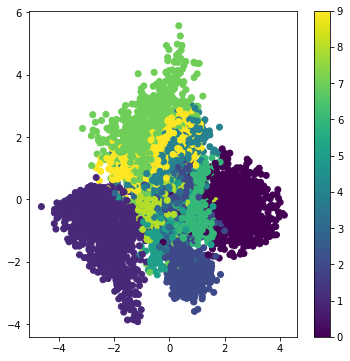

In [11]:
# 잠재 공간에 투영된 숫자 클래스의 2D 그래프
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

## [그림 2.7] 만들기

여기에서 어려운 부분은 보간을 위한 그리드를 만드는 것입니다. `np.linspace`를 사용해 `step_size` 간격으로 `min`과 `max` 사이를 이동합니다.

그다음 `for` 반복문에서 각 숫자 샘플의 생성하고 출력합니다!

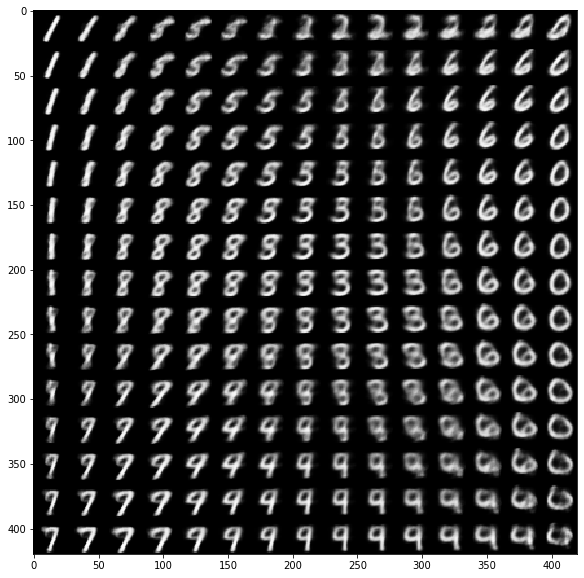

In [12]:
# 숫자의 2D 매니폴드 출력하기
n = 15  # 15x15 숫자를 담은 그림
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 잠재 공간을 가우스 분포로 가정했기 때문에 잠재 변수 z의 값을 만들기 위해
# 일정 간격으로 떨어진 좌표를 가우스 분포의 역 CDF(ppf)를 통해 변환합니다.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()